<a href="https://colab.research.google.com/github/tmannem/CovidPOC/blob/master/covidprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Stuff. Regular Nothing Big. Just adding Prophet here
Lots to be done
Code learnt from 
https://towardsdatascience.com/predicting-the-future-with-facebook-s-prophet-bdfe11af10ff

In [0]:
import pandas as pd
#pd.set_option('display.max_columns', None)
import numpy as np
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt
import io
#sample=

Read it Blah blah blah
This is the actual Data set

In [64]:

df2 = pd.read_csv('/var/data/full_data.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          8597 non-null   object
 1   location      8597 non-null   object
 2   new_cases     8597 non-null   int64 
 3   new_deaths    8597 non-null   int64 
 4   total_cases   8597 non-null   int64 
 5   total_deaths  8597 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 403.1+ KB


**** Filter only the world counts. For this POC that is what I wanted
The end goal is to create a map predicting it based on the location. Looks like Prophet is more one-D based. Need to see how we can include locations also in predicting ****


In [65]:
df2 = df2[df2['location']=='World']
df2.to_csv('groupedData1.csv')
df2['date'] = pd.to_datetime(df2['date'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 8472 to 8566
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          95 non-null     datetime64[ns]
 1   location      95 non-null     object        
 2   new_cases     95 non-null     int64         
 3   new_deaths    95 non-null     int64         
 4   total_cases   95 non-null     int64         
 5   total_deaths  95 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 5.2+ KB


** This is what we need where I get only the cases related to the count **

In [69]:
#df3 = df2.groupby("date").total_cases.sum().reset_index()
#df3['date'] = pd.to_datetime(df2['date'])
df3 = df2[['date','new_cases']]
df3.head()
df3.sort_values(by='date', ascending='true')


,date,new_cases
8472,2019-12-31,27
8473,2020-01-01,0
8474,2020-01-02,0
8475,2020-01-03,17
8476,2020-01-04,0
...,...,...
8562,2020-03-30,58487
8563,2020-03-31,62443
8564,2020-04-01,73512
8565,2020-04-02,77128


**plot blah blah**

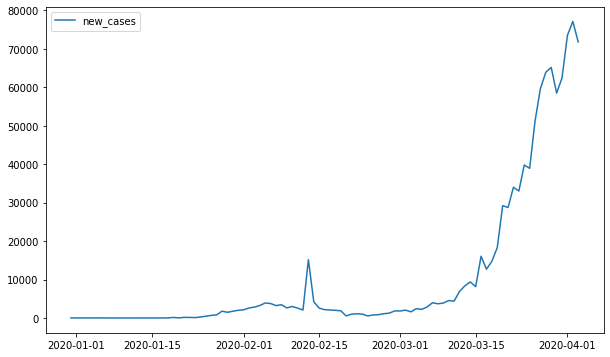

In [70]:
plt.figure(figsize=(10,6))
plt.plot(df3.set_index('date'))
plt.legend(['new_cases'])

Need to investigate why Prophet needs data in this format

In [71]:
df3.columns = ['ds','y']
df3.head()

,ds,y
8472,2019-12-31,27
8473,2020-01-01,0
8474,2020-01-02,0
8475,2020-01-03,17
8476,2020-01-04,0


**Seasonality. I changed it to False**

In [72]:
m1 = Prophet(daily_seasonality=False)
m1.fit(df3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


**Now run this model**

In [73]:
future1 = m1.make_future_dataframe(periods=30)
forecast1 = m1.predict(future1)
forecast1.tail().T

,120,121,122,123,124
ds,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00
trend,166392,169871,173350,176829,180307
yhat_lower,155852,160277,162612,165556,168243
yhat_upper,173856,180055,183166,187176,190472
trend_lower,156668,159650,162550,165402,168342
trend_upper,173930,177924,181911,185808,189737
additive_terms,-681.326,911.341,455.498,529.845,183.215
additive_terms_lower,-681.326,911.341,455.498,529.845,183.215
additive_terms_upper,-681.326,911.341,455.498,529.845,183.215
weekly,-681.326,911.341,455.498,529.845,183.215


In [74]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
120,2020-04-29,165710.801518,155852.482556,173855.647008
121,2020-04-30,170782.273910,160276.613066,180054.658246
122,2020-05-01,173805.235440,162611.644598,183166.451338
123,2020-05-02,177358.387933,165555.885207,187175.796037
124,2020-05-03,180490.563169,168243.076271,190472.036108


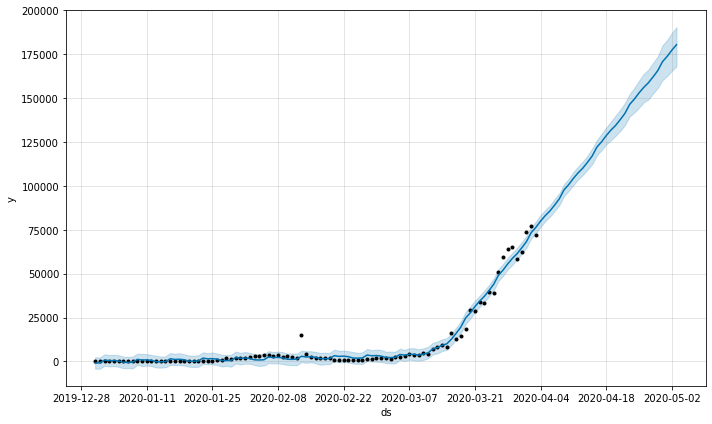

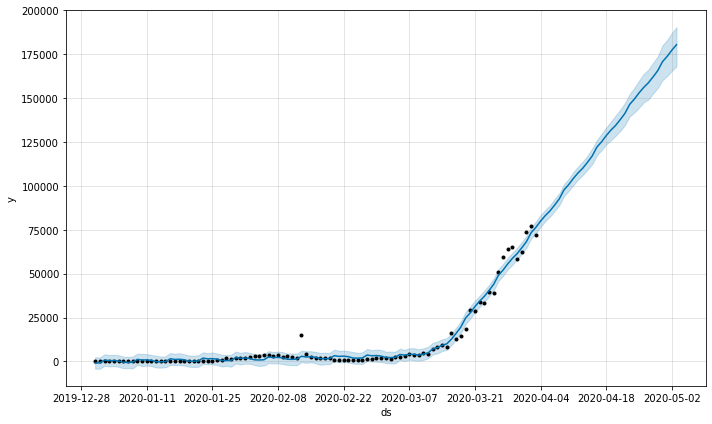

In [75]:
m1.plot(forecast1)

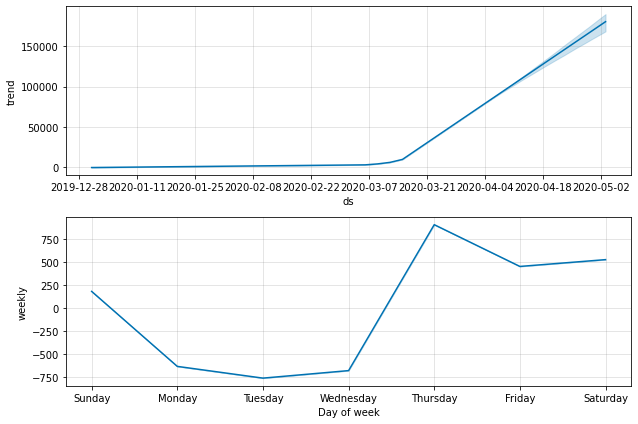

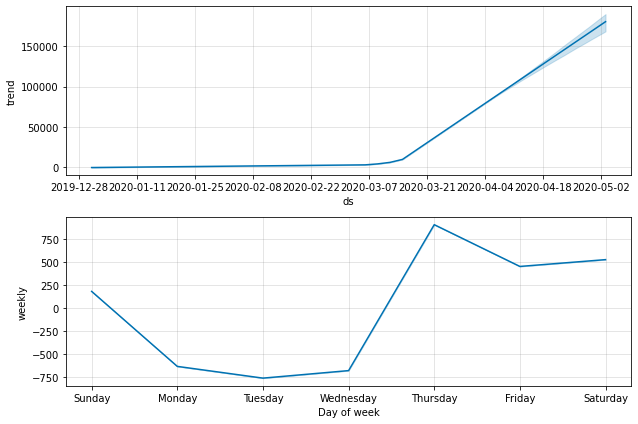

In [76]:
m1.plot_components(forecast1)

In [77]:
future1 = m1.make_future_dataframe(periods=10)
forecast2 = m1.predict(future1)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast2['total_cases']=pd.to_numeric(forecast2.yhat)
#forecast2['total_cases']
#forecast2["total_cases"] = np.exp(forecast2.yhat).round()
forecast2["total_cases_lower"] = forecast2.yhat_lower
forecast2["total_cases_upper"] = forecast2.yhat_upper
forecast2[(forecast2.ds > "04-03-2020") &(forecast2.ds < "4-07-2020")][["ds","total_cases_lower","total_cases", "total_cases_upper"]]

,ds,total_cases_lower,total_cases,total_cases_upper
95,2020-04-04,76864.599434,79951.847410,83223.860634
96,2020-04-05,80043.419752,83084.022646,86476.861109
97,2020-04-06,82429.203954,85744.370926,89012.205105
